<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/feature%2Fpredict_high/High_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [1]:
#!pip install yfinance

In [2]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
%matplotlib inline

In [3]:
from methods import load_data

# Готовим данные

In [4]:
stocks = load_data("msft", period_start="2021-01-01")
print(stocks.shape[0])
stocks.head()

[*********************100%***********************]  1 of 1 completed
294


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,220.224811,220.689943,212.584781,215.434952,37130100
2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000
2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700
2021-01-07,211.822758,217.067858,211.496190,216.028732,27694500
2021-01-08,216.414721,218.295048,214.781819,217.344986,22956200


## Размечаем таргет

Размечаем таргет...


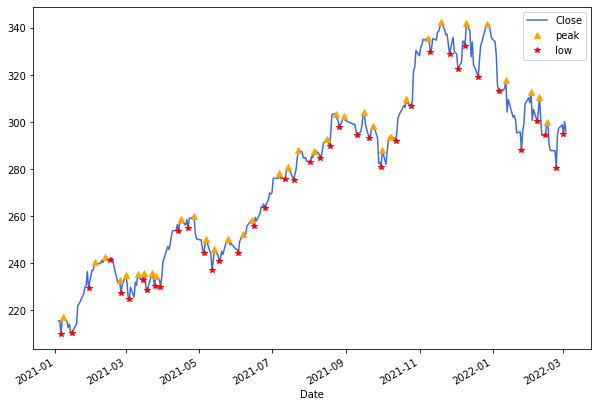

In [5]:
def mark_target(prices, window=10, how="high"):
  """Размечаем фактические точки лоу и хай"""
  if how == "high":
    facts = prices.rolling(window=window, center=True).max()
  elif how == "low":
    facts = prices.rolling(window=window, center=True).min()

  targets = np.zeros_like(prices)
  targets[prices==facts]=1
  return targets

def mark_data_targets(data):
  lows = mark_target(data["Close"], window=5, how="low")
  data["lows"] = lows
  peaks = mark_target(data["Close"], window=5)
  data["peaks"] = peaks

print("Размечаем таргет...")
mark_data_targets(stocks)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

## Расчитываем скользящие средние (СС)

Рассчитываем скользящие средние...


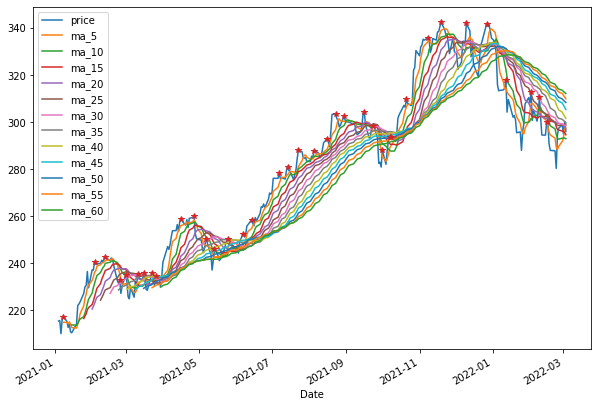

In [6]:
def create_ma(prices, ma_steps=[5,10,15,20]):
  """Фозвращает датафрейм с ценой и её скользящими средними заданной ширины"""
  result=pd.DataFrame()
  result["price"] = prices
  for ma_step in ma_steps:
    ma = prices.rolling(ma_step).mean()
    result["ma_{}".format(ma_step)] = ma
  return result

print("Рассчитываем скользящие средние...")
stocks_ma = create_ma(stocks["Close"], ma_steps=np.arange(5, 61, 5))

# Отрисовывем на обучении
_ = stocks_ma.plot(figsize=[10,7])
_ = stocks.loc[stocks["peaks"]==1, "Close"].plot(style="*")

## Отловим сигналы по СС

In [7]:
def find_sell_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА сверху"""
  short_higher = short_ma.shift(-1) > long_ma.shift(-1) #короткое было выше
  short_lower = short_ma.shift(1) < long_ma.shift(1) #короткое стало ниже

  sell_signals = short_higher & short_lower
  return sell_signals

def find_buy_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА снизу"""
  short_lower = short_ma.shift(-1) < long_ma.shift(-1) #короткое было выше
  short_higher = short_ma.shift(1) > long_ma.shift(1) #короткое стало ниже

  buy_signals = short_higher & short_lower
  return buy_signals

In [8]:
def form_signals(data_ma):
  sell_signals = pd.DataFrame()
  buy_signals = pd.DataFrame()

  for i in range(1, len(data_ma.columns)):
    short_ma_name = data_ma.columns[i]
    short_ma = data_ma[short_ma_name]
    for j in range(i, len(data_ma.columns)):
      long_ma_name = data_ma.columns[j]
      long_ma = data_ma[long_ma_name]

      sell_signals_name = "{0}_{1}_sell_signal".format(short_ma_name, long_ma_name)
      sell_signals[sell_signals_name] = find_sell_signals(short_ma, long_ma)

      buy_signals_name = "{0}_{1}_buy_signal".format(short_ma_name, long_ma_name)
      buy_signals[buy_signals_name] = find_buy_signals(short_ma, long_ma)

  sell_signals= sell_signals.copy().astype(int)
  buy_signals= buy_signals.copy().astype(int)

  return sell_signals, buy_signals

In [9]:
sell_signals, buy_signals = form_signals(stocks_ma)

## Разделение на обучение и тест

In [10]:
train_size = int(stocks_ma.shape[0]*2/3)
stocks_ma_train = stocks_ma[:train_size].copy(deep=True)
stocks_ma_test = stocks_ma[train_size:].copy(deep=True)

# Обучение

## Валидатор стратегии

In [11]:
def validate (stocks, start_money = 1000, start_eq=0, verbose=0):
  """
    Играем по стратегии: при сигнале на покупку покупаем всё, при сигнале на продажу - продаём всё
  """
  def _print(txt, priority):
    if priority<verbose:
      print(txt)

  money_hist = list()

  money = start_money
  eq = start_eq
  _print("Денег в начале стратегии: {0}".format(money), 0)

  for row in stocks.iterrows():
    r = row[1]

    if ~np.isnan(r["buy_signal"]): #сигнал на покупку
      if money>0: #деньги есть
        price = r["price"]
        available_eq = np.floor(money/price)
        eq += available_eq
        money-=available_eq*price
        _print("{0}: Покупаем {1}  по цене {2}, остаток средств: {3}".format(row[0], available_eq, price, money),1)
    if ~np.isnan(r["sell_signal"]): #сигнал на продажу
      if eq>0: #есть что продать
        price = r["price"]
        sell_eq = eq
        eq = 0
        money+=sell_eq*price
        _print("{0}: Продаём {1}  по цене {2}, остаток средств: {3}".format(row[0], sell_eq, price, money), 1)
    #записываем историю нашего благосоятояния
    money_hist.append(money)

    #запоминаем последнюю цену
    last_price = r["price"]

  #фиксим прибыль
  money += last_price * eq 
  eq = 0

  _print("Денег в конце стратегии: {0}".format(money), 0)

  return money_hist, money, eq


## Выбираем какая пара СС лучше предсказывает пик
пока лучшее, что было придумано - количество пропущенных пиков и рпсстояние до них
TODO: придумать адекватную метрики качества обнаружения пиков

In [12]:
#перебираем различные комбинации поиска сигналов на продажу и сигналов на покупку
ss_bs_chose_data = pd.DataFrame()
ss_bs_chose_data["price"] = stocks_ma_train["price"] 
ma_results = dict()

for ss_name in sell_signals.columns:
  ss_bs_chose_data["sell_signal"] = np.NaN
  ss_bs_chose_data.loc[sell_signals[ss_name]>0, "sell_signal"] = ss_bs_chose_data.loc[sell_signals[ss_name]>0, "price"]
  
  for bs_name in buy_signals.columns: 
    ss_bs_chose_data["buy_signal"] = np.NaN
    ss_bs_chose_data.loc[buy_signals[bs_name]>0, "buy_signal"] = ss_bs_chose_data.loc[buy_signals[bs_name]>0, "price"] 
    money_hist, money, eq = validate(ss_bs_chose_data, start_money = 10000, verbose=0)
    ma_results[ss_name+"+"+bs_name] = money

In [13]:
ma_results_pd = pd.DataFrame.from_dict(ma_results, orient="index", columns=["result"])
ma_results_pd.sort_values(by="result", ascending=False).head()

,result
ma_45_ma_55_sell_signal+ma_15_ma_35_buy_signal,13670.204376
ma_5_ma_20_sell_signal+ma_5_ma_50_buy_signal,13663.400009
ma_45_ma_55_sell_signal+ma_10_ma_40_buy_signal,13644.632065
ma_45_ma_50_sell_signal+ma_15_ma_35_buy_signal,13564.133087
ma_45_ma_50_sell_signal+ma_10_ma_40_buy_signal,13538.560776


In [14]:
chosen_sell_signals, chosen_buy_signals = ma_results_pd.sort_values(by="result", ascending=False).index.values[0].split("+")

In [15]:
print(chosen_sell_signals)
print(chosen_buy_signals)

ma_45_ma_55_sell_signal
ma_15_ma_35_buy_signal


# Применяем выбранные СС

In [16]:
def apply_strategy(data, sell_signals, buy_signals, chosen_sell_signals, chosen_buy_signals):
  result = pd.DataFrame()
  result["price"] = data["price"]

  result["sell_signal"] = np.NaN
  result.loc[sell_signals[chosen_sell_signals]>0, "sell_signal"] = data.loc[sell_signals[chosen_sell_signals]>0, "price"] 

  result["buy_signal"] = np.NaN
  result.loc[buy_signals[chosen_buy_signals]>0, "buy_signal"] = data.loc[buy_signals[chosen_buy_signals]>0, "price"] 

  return result
 #data["price"] = data["price"]

In [17]:
train_data = apply_strategy(stocks_ma_train, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

test_data = apply_strategy(stocks_ma_test, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

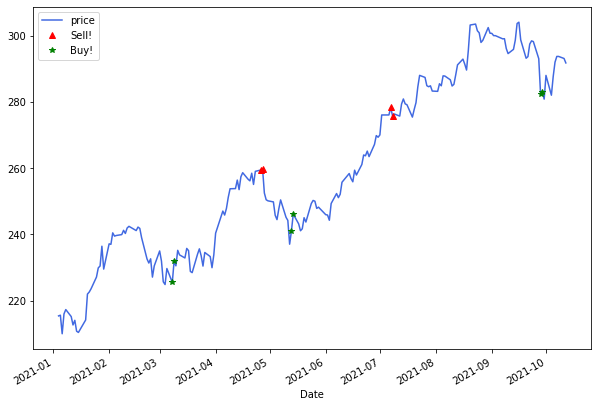

In [35]:
train_data["price"].plot(figsize=[10,7], color="royalblue")
train_data.loc[~np.isnan(train_data["sell_signal"]), "price"].plot(style="^", label="Sell!", color="red")
train_data.loc[~np.isnan(train_data["buy_signal"]), "price"].plot(style="*", label="Buy!", color="green")
plt.legend()

# Валидация стратегии

In [36]:
money_hist_train, money_train, eq_train = validate(train_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-03-08 00:00:00: Покупаем 44.0  по цене 225.5527801513672, остаток средств: 75.67767333984375
2021-03-09 00:00:00: Покупаем 0.0  по цене 231.89112854003906, остаток средств: 75.67767333984375
2021-04-26 00:00:00: Продаём 44.0  по цене 259.436767578125, остаток средств: 11490.895446777344
2021-05-13 00:00:00: Покупаем 47.0  по цене 241.06640625, остаток средств: 160.77435302734375
2021-05-14 00:00:00: Покупаем 0.0  по цене 246.14505004882812, остаток средств: 160.77435302734375
2021-07-07 00:00:00: Продаём 47.0  по цене 278.3094177246094, остаток средств: 13241.316986083984
2021-09-28 00:00:00: Покупаем 46.0  по цене 282.41827392578125, остаток средств: 250.07638549804688
2021-09-29 00:00:00: Покупаем 0.0  по цене 282.8963928222656, остаток средств: 250.07638549804688
Денег в конце стратегии: 13670.204376220703


In [37]:
money_hist_test, money_test, eq_test = validate(test_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-12-13 00:00:00: Покупаем 29.0  по цене 338.69964599609375, остаток средств: 177.71026611328125
2021-12-14 00:00:00: Покупаем 0.0  по цене 327.6624755859375, остаток средств: 177.71026611328125
Денег в конце стратегии: 8759.390655517578


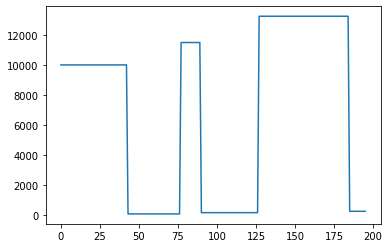

In [38]:
plt.plot(money_hist_train)